# Testing KMEANS

In [92]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Electricity raw ED clustering

In [93]:
X = np.load('electricity/data/electricity.npy')

In [94]:
X.shape

(370, 26136)

In [95]:
kmeans = KMeans(n_clusters=10, random_state=0, verbose=0)

In [96]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [97]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
num_in_cluster = dict(zip(unique, counts))
num_in_cluster

{0: 21, 1: 1, 2: 1, 3: 277, 4: 1, 5: 1, 6: 2, 7: 13, 8: 4, 9: 49}

In [98]:
centers = kmeans.cluster_centers_

In [99]:
d = {f"cluster_{i}" : l for i, l in enumerate(centers[:,15000:15168])}

In [100]:
df = pd.DataFrame(d)

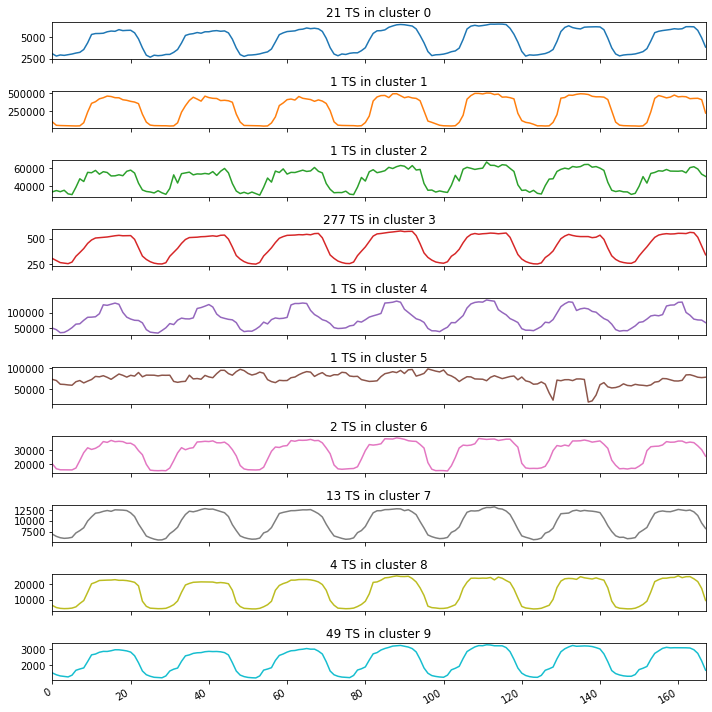

In [101]:
titles = [f"{num_in_cluster[i]} TS in cluster {i}" for i in range(len(kmeans.cluster_centers_))]
df.plot(figsize=(10,len(kmeans.cluster_centers_)), subplots=True, title=titles, legend=False)
plt.tight_layout()
plt.show()

# Shapes

In [102]:
def shape_series(
    shape, length=100, period=10, mean=0, var=1, noise=None, noise_var=1
):
    """ Creates a shape series and adds noise to it. """
    assert shape in ["sine", "triangle", "square"]
    assert noise in [None, "iid", "matern"]
    if shape == "sine":
        s = sine(length, period, mean, var)
    elif shape == "square":
        s = square(length, period, mean, var)
    elif shape == "triangle":
        s = triangle(length, period, mean, var)
    if noise == "iid":
        s = iid_noise(s)
    elif noise == "matern":
        s = matern_noise(s)
    return s

def sine(t, p, mean=0, var=1, start=1):
    """ Creating a sine signal with period p. """
    x = np.linspace(1, t, t)
    s = np.sin(1 / p * x * 2 * np.pi)
    s = s * var + mean
    assert len(s) == t
    return s

def triangle(t, p, mean=0, var=1, start=1):
    """ Creating a triangle signal with period p. """
    y = np.array([(1 - 2 / p * x) for x in range(p)])
    s = np.tile(
        np.concatenate((start * y, -start * y), axis=None), t // (2 * p) + 1
    )[:t]
    s = s * var + mean
    assert len(s) == t
    return s

def square(t, p, mean=0, var=1, start=1):
    """ Creating a square signal that alternates every p step. """
    s = np.tile(
        np.concatenate((start * np.ones(p), -start * np.ones(p)), axis=None),
        t // (2 * p) + 1,
    )[:t]
    s = s * var + mean
    assert len(s) == t
    return s

def iid_noise(x, var=0.2):
    noise = var * np.random.randn(len(x))
    x += noise
    return x

def matern_noise(s, var=1, nu=1.5):
    """ nu determines the smoothness. smaller is less smooth """
    gp = GaussianProcessRegressor(
        kernel=var * Matern(length_scale=10, length_scale_bounds=(1e-5, 1e5), nu=nu)
    )
    x = np.linspace(1, len(s), len(s))
    sample = gp.sample_y(x.reshape(-1, 1), 1, random_state=None).flatten()

    return s + sample

In [103]:
def create_shape_series(
        N: int, t: int, balance: bool, mean: float = 0, var: float = 1.0
    ):
        ts = []
        descriptive = []
        for i in range(N):
            # Randomly choose shape, frequency and noise
            shape = np.random.choice(["sine", "square", "triangle"])
            noise = np.random.choice(["iid", "matern", None])
            period = np.random.choice([2, 10, 20])
            s = shape_series(
                shape, length=t, period=period, noise=noise, mean=mean, var=var
            )
            ts.append(s)
            descriptive.append([shape, noise, str(period)])

        df_ts = pd.DataFrame(ts)
        df_descriptive = pd.DataFrame(descriptive)
        df_descriptive.columns = ["shape", "noise", "period"]
        return df_ts, df_descriptive

In [104]:
df, _ = create_shape_series(N=2000, t=100, mean=10, var=1.0, balance=False)

In [105]:
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,10.863039,10.704803,10.980329,10.903782,10.773797,10.630214,11.217405,10.853771,10.997713,10.923538,...,8.947492,8.772662,8.681248,8.876880,9.001723,9.209115,8.956308,9.313981,9.164129,9.085248
1,10.769546,10.819488,10.507996,9.919344,9.309951,8.929345,8.919262,9.079793,9.524090,10.258015,...,10.673752,11.199570,11.434648,11.310875,10.928133,10.335859,10.099808,10.233097,10.804045,11.647095
2,11.070836,11.054123,8.716064,9.069007,11.089181,10.781625,8.960281,9.234121,11.144370,11.015945,...,8.680370,8.669096,11.254158,10.632370,8.902582,8.589898,11.342763,11.126308,8.825928,8.998324
3,11.000000,11.000000,9.000000,9.000000,11.000000,11.000000,9.000000,9.000000,11.000000,11.000000,...,9.000000,9.000000,11.000000,11.000000,9.000000,9.000000,11.000000,11.000000,9.000000,9.000000
4,11.000000,10.000000,9.000000,10.000000,11.000000,10.000000,9.000000,10.000000,11.000000,10.000000,...,9.000000,10.000000,11.000000,10.000000,9.000000,10.000000,11.000000,10.000000,9.000000,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1996,10.309017,10.587785,10.809017,10.951057,11.000000,10.951057,10.809017,10.587785,10.309017,10.000000,...,9.690983,9.412215,9.190983,9.048943,9.000000,9.048943,9.190983,9.412215,9.690983,10.000000
1997,10.567552,10.644709,10.656933,10.622147,10.531707,10.356924,10.227043,10.179244,10.137432,10.158433,...,10.242252,10.336772,10.292822,10.316615,10.310434,10.292792,10.355068,10.323159,10.286451,10.113304
1998,11.338250,10.975940,10.747085,10.191293,10.121113,10.156353,9.881801,9.454204,9.511553,9.386644,...,8.481274,8.866055,9.692916,9.844794,9.914736,9.932499,10.273918,10.305306,10.569034,10.769480


In [106]:
X = df.values

In [107]:
kmeans = KMeans(n_clusters=30, random_state=0, verbose=0)

In [108]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [109]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
num_in_cluster = dict(zip(unique, counts))
num_in_cluster

{0: 21,
 1: 21,
 2: 180,
 3: 199,
 4: 15,
 5: 175,
 6: 17,
 7: 183,
 8: 177,
 9: 16,
 10: 16,
 11: 185,
 12: 18,
 13: 22,
 14: 170,
 15: 14,
 16: 11,
 17: 14,
 18: 11,
 19: 24,
 20: 21,
 21: 13,
 22: 196,
 23: 23,
 24: 16,
 25: 22,
 26: 16,
 27: 18,
 28: 20,
 29: 166}

In [110]:
centers = kmeans.cluster_centers_

In [111]:
d = {f"cluster_{i}" : l for i, l in enumerate(centers[:,25:75])}

In [112]:
df = pd.DataFrame(d)

In [113]:
df.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29
0,11.455492,10.858804,10.017861,9.995554,9.430547,9.340621,8.764699,9.479845,9.060928,8.559249,...,11.977616,10.136568,10.987011,10.020046,7.953933,11.023164,11.160241,12.014337,9.278252,10.907691
1,11.364231,8.879849,10.010122,9.013600,9.562683,8.999432,8.703027,9.585268,9.042460,8.061939,...,11.889674,10.097902,8.974290,9.907539,7.926416,10.435283,10.853717,10.282667,8.730558,10.753807
2,11.251721,8.923989,10.029047,10.004846,9.653633,8.958190,8.700928,9.681888,9.024396,8.260609,...,11.745616,10.135171,8.990042,9.960082,7.884248,10.781239,10.738225,10.507444,8.820077,10.547981
3,11.125807,10.951300,10.007952,10.992057,9.718863,9.340201,8.730529,9.795774,9.051467,8.548597,...,11.571198,10.092266,11.010396,10.062286,7.872119,11.300462,10.804435,12.257206,9.157142,10.264557
4,11.000364,10.941182,10.009641,10.004560,9.778201,9.893276,8.798309,9.888138,9.034538,8.291722,...,11.372131,9.826509,11.002614,10.129911,7.862858,10.956342,10.989536,11.969379,8.902452,9.946507


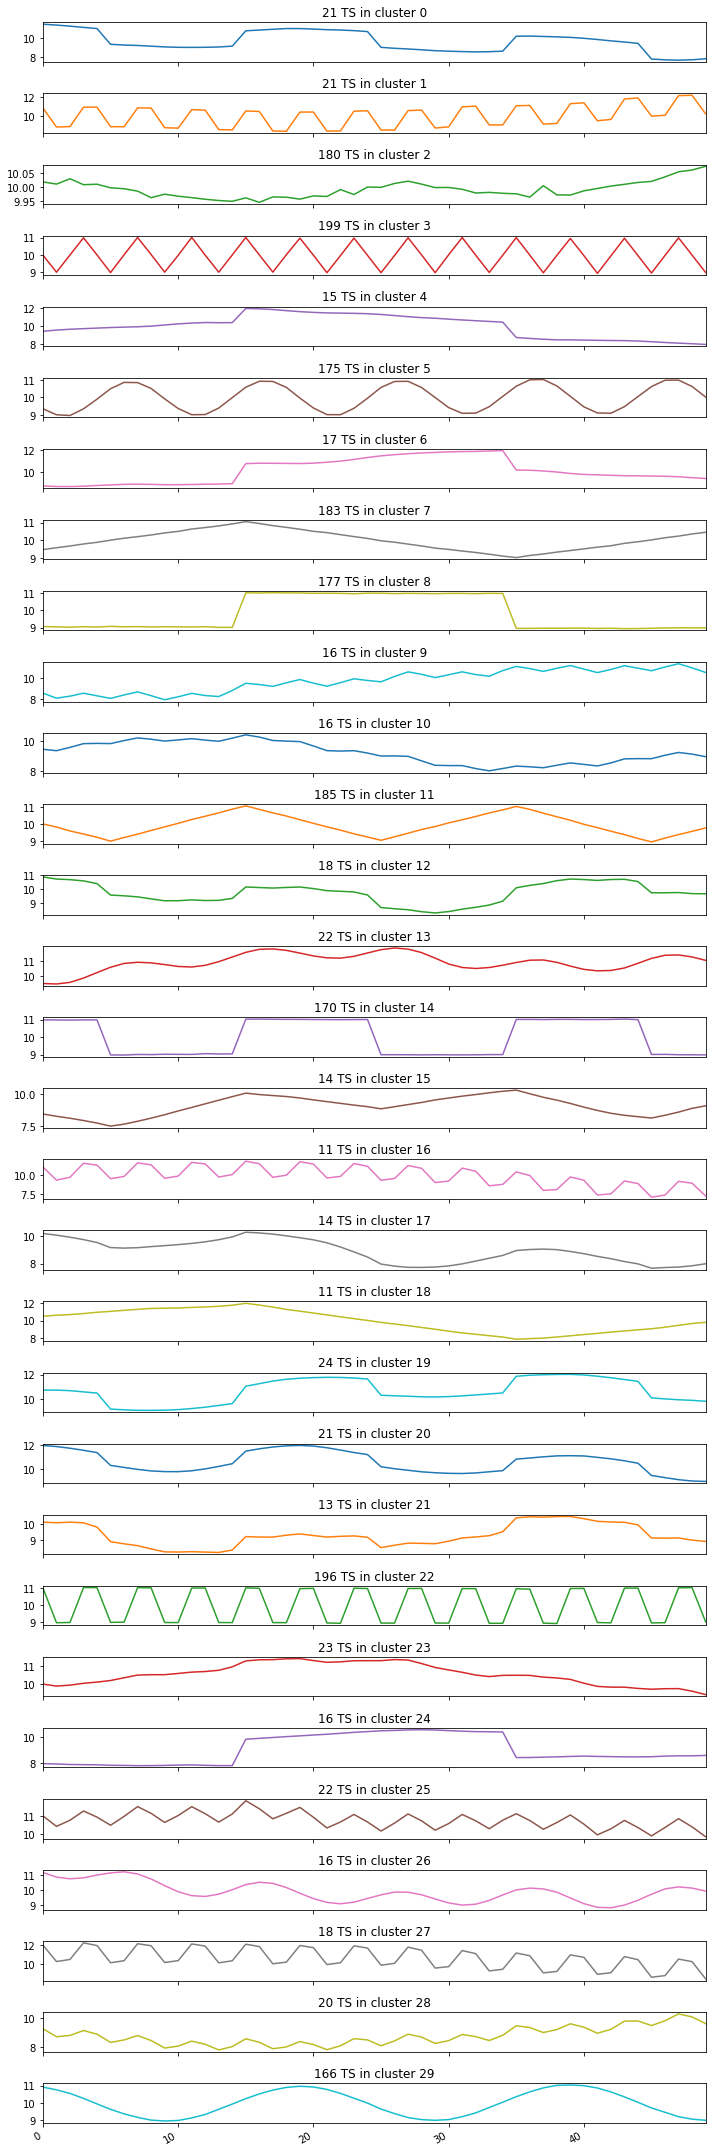

In [114]:
titles = [f"{num_in_cluster[i]} TS in cluster {i}" for i in range(len(kmeans.cluster_centers_))]
df.plot(figsize=(10,len(kmeans.cluster_centers_)), subplots=True, title=titles, legend=False)
plt.tight_layout()
plt.show()

# Revenue embedded ID clustering

In [115]:
MODEL_PATH = "revenue/models/tcn_3_4_32_False_embed_True_dim_5"

In [116]:
from revenue.model import TCN
from revenue.data import RevenueDataset
import torch
import pandas as pd
from torch.utils.data import DataLoader
import pickle
import numpy as np

In [117]:
dataset = RevenueDataset(
    file_path="revenue\data\processed_companies.csv",
    meta_path="revenue\data\comp_sect_meta.csv",
    start_date="2007-01-01",
    end_date="2017-01-01",
    receptive_field=10,
)
dataloader = DataLoader(dataset=dataset, batch_size=1, num_workers=0, shuffle=False)

Dimension of X :  torch.Size([15229, 1, 40])
Dimension of Y :  torch.Size([15229, 1, 40])


In [118]:
# Read in model
model = TCN(
        num_layers=3,
        in_channels=1,
        out_channels=1,
        residual_blocks_channel_size=[32]*3,
        kernel_size=4,
        num_embeddings=dataset.num_ts,
        embedding_dim=5,
        embed='post',
        dilated_convolutions=False,
        )
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

[1, 1, 1]


TCN(
  (tcn): TemporalConvolutionalNetwork(
    (net): Sequential(
      (0): ResidualBlock(
        (dcc1): DilatedCausalConv(1, 32, kernel_size=(4,), stride=(1,))
        (drop1): Dropout(p=0.5, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop2): Dropout(p=0.5, inplace=False)
        (res_conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualBlock(
        (dcc1): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop1): Dropout(p=0.5, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop2): Dropout(p=0.5, inplace=False)
      )
      (2): ResidualBlock(
        (dcc1): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop1): Dropout(p=0.5, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (conv1d): DilatedCausalConv(32, 1, 

In [119]:
embeddings = {}
for i, d in enumerate(dataloader):
    x, y, idx, idx_row = d[0], d[1], d[2], d[3]
    embeddings[idx_row.item()] = model.embedding(idx_row).detach().numpy().flatten()

In [120]:
df = pd.DataFrame(embeddings).T

In [121]:
X = df.values

In [135]:
# PLotting using T-SNE
from sklearn.manifold import TSNE
emb_2d = X_embedded = TSNE(n_components=3, verbose=1).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15229 samples in 0.039s...
[t-SNE] Computed neighbors for 15229 samples in 0.881s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15229
[t-SNE] Computed conditional probabilities for sample 2000 / 15229
[t-SNE] Computed conditional probabilities for sample 3000 / 15229
[t-SNE] Computed conditional probabilities for sample 4000 / 15229
[t-SNE] Computed conditional probabilities for sample 5000 / 15229
[t-SNE] Computed conditional probabilities for sample 6000 / 15229
[t-SNE] Computed conditional probabilities for sample 7000 / 15229
[t-SNE] Computed conditional probabilities for sample 8000 / 15229
[t-SNE] Computed conditional probabilities for sample 9000 / 15229
[t-SNE] Computed conditional probabilities for sample 10000 / 15229
[t-SNE] Computed conditional probabilities for sample 11000 / 15229
[t-SNE] Computed conditional probabilities for sample 12000 / 15229
[t-SNE] Computed conditional probabilities for sam

In [136]:
emb_2d[:,0].shape

(15229,)

In [137]:
sectors = [dataset.comp_sect_dict[dataset.id_companies_dict[i]][0] for i in range(emb_2d.shape[0])]

In [138]:
df = pd.DataFrame({"x":emb_2d[:,0], "y":emb_2d[:,1], "z":emb_2d[:,2] "sect":sectors})
df.head()

SyntaxError: invalid syntax (<ipython-input-138-18470b1b0384>, line 1)

In [ ]:
import plotly.express as px
fig = px.scatter_3d(
    df, x="x", y="y", z="z", 
    color='sect', 
    )
fig.show()

In [32]:
kmeans = KMeans(n_clusters=30, random_state=0, verbose=0)

In [33]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [34]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
num_in_cluster = dict(zip(unique, counts))
num_in_cluster

{0: 9664,
 1: 27,
 2: 92,
 3: 42,
 4: 143,
 5: 73,
 6: 10,
 7: 15,
 8: 271,
 9: 146,
 10: 61,
 11: 813,
 12: 82,
 13: 4,
 14: 38,
 15: 11,
 16: 232,
 17: 20,
 18: 98,
 19: 417,
 20: 2031,
 21: 45,
 22: 128,
 23: 14,
 24: 171,
 25: 88,
 26: 33,
 27: 30,
 28: 17,
 29: 413}

In [35]:
dists = kmeans.transform(X)

array([[0.05535001, 8.566402  , 4.660229  , ..., 5.5858483 , 9.570668  ,
        0.3012474 ],
       [0.02761462, 8.596237  , 4.6900425 , ..., 5.5560193 , 9.6004925 ,
        0.27128223],
       [0.02346739, 8.626509  , 4.7203045 , ..., 5.525769  , 9.630755  ,
        0.24141529],
       ...,
       [0.08926305, 8.532159  , 4.625982  , ..., 5.6201572 , 9.536415  ,
        0.3358192 ],
       [0.02144574, 8.603478  , 4.6972833 , ..., 5.548767  , 9.6077385 ,
        0.26394877],
       [0.02464712, 8.625661  , 4.719476  , ..., 5.5266047 , 9.629911  ,
        0.2424298 ]], dtype=float32)

In [53]:
dists.shape

(15229, 30)

In [60]:
np.sort(dists[:,1])

array([1.7196665e-02, 2.1964790e-02, 4.5931958e-02, ..., 1.8602547e+01,
       1.9391907e+01, 2.0030449e+01], dtype=float32)

In [52]:
dists[0:4]

array([[ 0.05535001,  8.566402  ,  4.660229  ,  4.5369534 ,  1.9344028 ,
         2.8371468 , 13.456627  ,  9.352515  ,  1.0112444 ,  1.289743  ,
         5.5756955 ,  0.2996664 ,  3.1864457 , 18.958557  ,  7.374354  ,
        12.129806  ,  0.7441064 ,  6.8574815 ,  2.052847  ,  0.61313266,
         0.07790781,  3.5644825 ,  2.5558567 , 10.876895  ,  1.4514644 ,
         3.7865922 ,  6.494889  ,  5.5858483 ,  9.570668  ,  0.3012474 ],
       [ 0.02761462,  8.596237  ,  4.6900425 ,  4.507125  ,  1.9642285 ,
         2.8072844 , 13.486449  ,  9.322675  ,  1.0409939 ,  1.2598109 ,
         5.6055136 ,  0.32927266,  3.216247  , 18.988379  ,  7.404182  ,
        12.159629  ,  0.71417385,  6.827646  ,  2.0229836 ,  0.64283365,
         0.10636679,  3.5346413 ,  2.585662  , 10.906735  ,  1.481255  ,
         3.8164105 ,  6.5247188 ,  5.5560193 ,  9.6004925 ,  0.27128223],
       [ 0.02346739,  8.626509  ,  4.7203045 ,  4.476885  ,  1.994502  ,
         2.777069  , 13.5167055 ,  9.292445  ,  1

In [50]:
np.argsort(dists[:, 3])[::-1][:10]

array([ 3088, 14834,  2008,  5904, 15078,  5930, 14387,  7648,  1470,
        1282], dtype=int64)

In [68]:
np.argsort(dists[:, 3])[::-1][:10].tolist()


[3088, 14834, 2008, 5904, 15078, 5930, 14387, 7648, 1470, 1282]

In [79]:
dataset.X[3088].detach().numpy().flatten()

array([      0.,       0.,       0.,       0.,       0.,       0.,
             0.,       0.,       0.,       0.,       0.,       0.,
        283158.,  353475.,  442117.,  509411.,  541138.,  588769.,
        703524.,  750132.,  788960.,  899158., 1108023., 1075810.,
       1080961., 1210928., 1329574., 1341388., 1279242., 1443472.,
       1630062., 1675083., 1523665., 1731675., 1974914., 1941650.,
       1854078., 2212029., 2197035., 2229977.], dtype=float32)

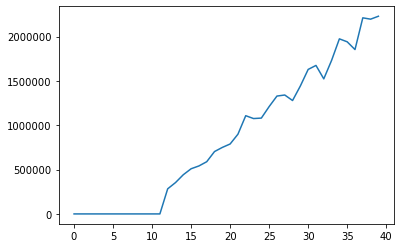

In [80]:
plt.plot(dataset.X[3088].detach().numpy().flatten())

In [70]:
approx_proto = []
for c in range(dists.shape[1]):
    prots = dataset.X[(np.argsort(dists[:, c])[::-1][:10].tolist())].reshape(10,-1).detach().numpy()
    #print(prots)
    print([dataset.id_companies_dict[p] for p in (np.argsort(dists[:, c])[::-1][:10].tolist())])
    approx_proto.append(np.true_divide(prots.sum(0),(prots!=0).sum(0)))

['PT Midi Utama Indonesia Tbk', 'PT Telekomunikasi Indonesia (Persero) Tbk', 'GS Retail Co., Ltd.', 'PT PP (Persero) Tbk', 'Korea Electric Power Corp.', 'China State Construction Engineering Corp. Ltd.', 'Taiwan Semiconductor Manufacturing Co., Ltd.', 'Green Cross Corp.', 'Subaru Corp.', 'SAIC Motor Corp. Ltd.']
['Solar Alliance Energy, Inc.', 'Pattern Energy Group, Inc.', 'Avangrid, Inc.', 'Just Energy Group, Inc.', 'Essential Utilities, Inc.', 'SJW Group', 'Connecticut Water Service, Inc.', 'Middlesex Water Co.', 'Cadiz, Inc.', 'California Water Service Group']
['NEC Corp.', 'Sojitz Corp.', 'PT Midi Utama Indonesia Tbk', 'HNK MACHINE TOOL Co., Ltd.', 'Tokyo Electric Power Co. Holdings, Inc.', 'DISPLAY TECH Co., Ltd.', 'PT Telekomunikasi Indonesia (Persero) Tbk', 'GS Retail Co., Ltd.', 'PT PP (Persero) Tbk', 'Yamada Denki Co., Ltd.']
['PT Midi Utama Indonesia Tbk', 'PT Telekomunikasi Indonesia (Persero) Tbk', 'GS Retail Co., Ltd.', 'PT PP (Persero) Tbk', 'Korea Electric Power Corp.', 

In [37]:
d = {f"cluster_{i}" : l for i, l in enumerate(approx_proto)}

In [38]:
df = pd.DataFrame(d)
df.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29
0,3.662459e+06,40189.0,5.041906e+06,3.662459e+06,7.261859e+06,3.662459e+06,40189.0,3.662459e+06,4.389876e+06,3.662459e+06,...,3.662459e+06,3.662459e+06,5456441.0,40189.0,4.389876e+06,5.041906e+06,40189.0,3.662459e+06,40189.0,3.662459e+06
1,3.833381e+06,38846.0,5.359460e+06,3.833381e+06,7.596397e+06,3.833381e+06,38846.0,3.833381e+06,4.594960e+06,3.833381e+06,...,3.833381e+06,3.833381e+06,5707010.0,38846.0,4.594960e+06,5.359460e+06,38846.0,3.833381e+06,38846.0,3.833381e+06
2,3.952475e+06,50272.0,5.384824e+06,3.952475e+06,7.825784e+06,3.952475e+06,50272.0,3.952475e+06,4.737810e+06,3.952475e+06,...,3.952475e+06,3.952475e+06,5881906.0,50272.0,4.737810e+06,5.384824e+06,50272.0,3.952475e+06,50272.0,3.952475e+06
3,3.366710e+06,43474.0,5.052285e+06,3.366710e+06,5.833343e+06,3.366710e+06,43474.0,3.366710e+06,3.923258e+06,3.366710e+06,...,3.366710e+06,3.366710e+06,5829701.0,43474.0,3.923258e+06,5.052285e+06,43474.0,3.366710e+06,43474.0,3.366710e+06
4,3.297990e+06,39996.0,5.263791e+06,3.297990e+06,5.715494e+06,3.297990e+06,39996.0,3.297990e+06,3.842852e+06,3.297990e+06,...,3.297990e+06,3.297990e+06,5716235.0,39996.0,3.842852e+06,5.263791e+06,39996.0,3.297990e+06,39996.0,3.297990e+06


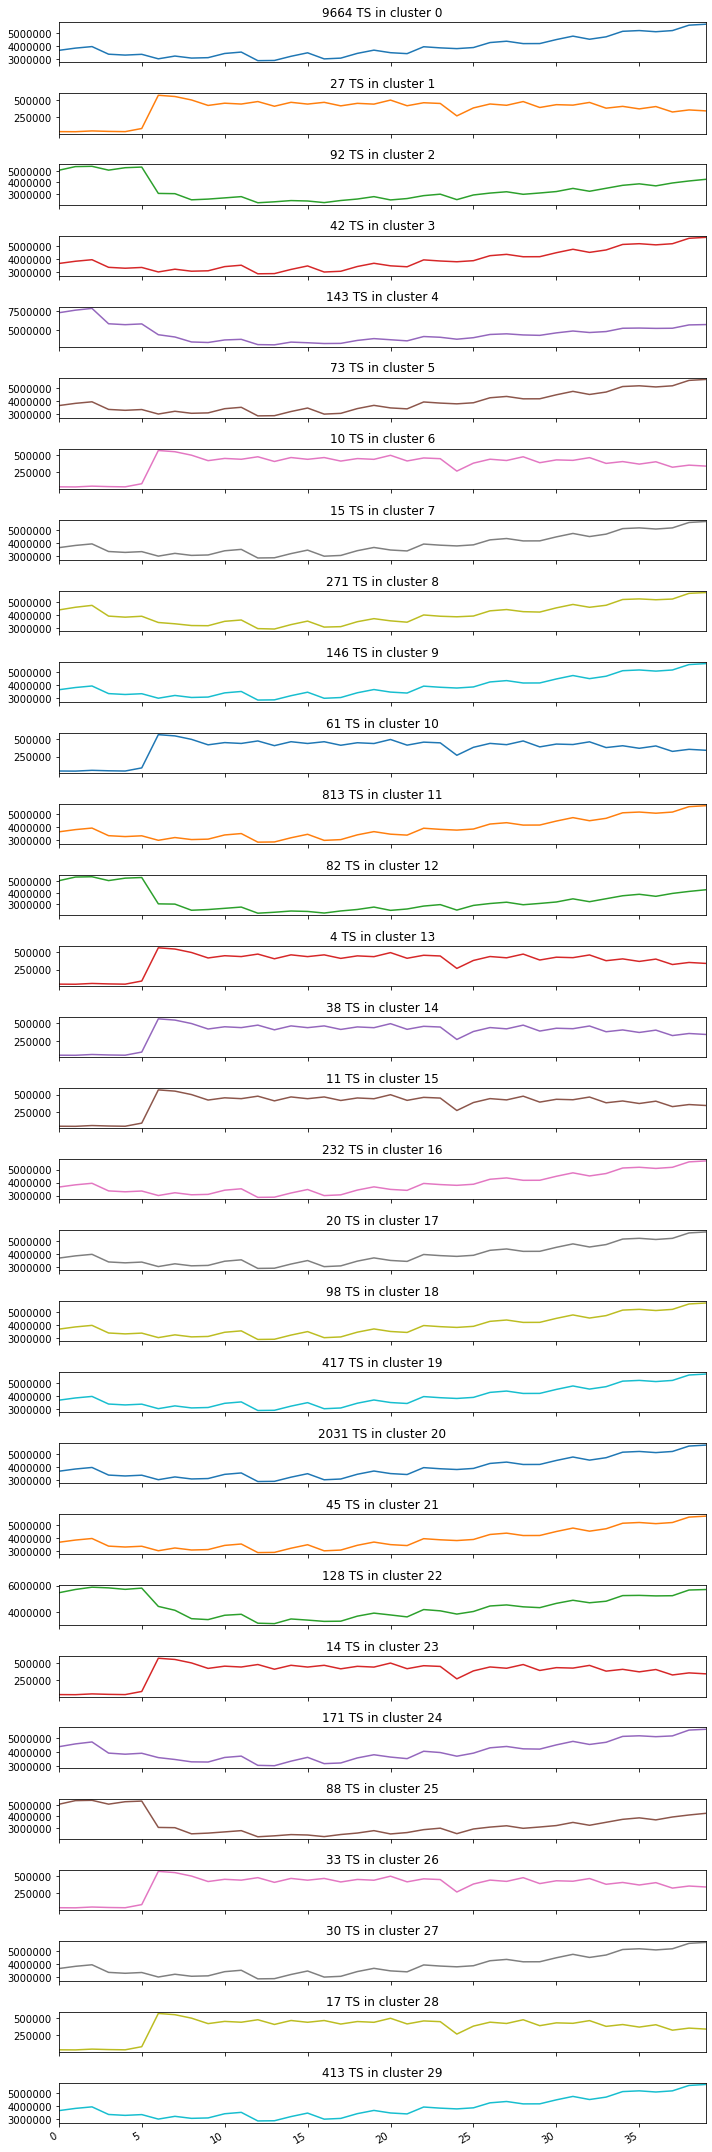

In [39]:
titles = [f"{num_in_cluster[i]} TS in cluster {i}" for i in range(len(kmeans.cluster_centers_))]
df.plot(figsize=(10,len(kmeans.cluster_centers_)), subplots=True, title=titles, legend=False)
plt.tight_layout()
plt.show()

# Revenue ED raw series